In [28]:
import os 
import re
import pandas as pd
from num2words import num2words

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)


# Pre-Process

In [2]:

def load_files_and_split_articles(directory):
    all_articles = []
    if not os.path.exists(directory):
        raise ValueError(f"Directory {directory} does not exist.")

    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            filepath = os.path.join(directory, filename)
            try:
                with open(filepath, "r", encoding="utf-8") as f:
                    text = f.read().lower()
                    articles = re.split(r'document\s+\w{25}', text)
                    articles = [article.strip() for article in articles if article.strip() != ""]
                    all_articles.extend(articles)
            except Exception as e:
                print(f"Error reading {filename}: {e}")
    return all_articles

articles = load_files_and_split_articles("DataDictionary/Articles")
print(f"Total number of articles extracted: {len(articles)}")

Total number of articles extracted: 1641


# Preprocessing and exploratory data analysis

## Data Preprocessing

clean up the corpus, make sure you separate meta-data from the actual articles

In [3]:
def separate_metadata(article):
    # Regex pattern for the end of the metadata
    end_of_metadata_pattern = re.compile(
        r'All Rights Reserved\.|Copyright \d{4}\. Dow Jones & Company, Inc\.',
        re.IGNORECASE
    )
    match = end_of_metadata_pattern.search(article)

    if match:
        end_of_metadata_index = match.end()
        # The metadata is from the beginning of the article to the end of the matched pattern
        metadata = article[:end_of_metadata_index].strip()
        # The content is from the end of the matched pattern to the end of the article
        content = article[end_of_metadata_index:].strip()
        return metadata, content
    else:
        return "", article


In [4]:
metadatas = []
contents = []
for article in articles:
    metadata, content = separate_metadata(article)
    metadatas.append(metadata)
    contents.append(content)
print(f"Total number of metadatas extracted: {len(metadatas)}")
print(f"Total number of contents extracted: {len(contents)}")


Total number of metadatas extracted: 1641
Total number of contents extracted: 1641


In [5]:
def remove_punctuation(article):
    punctuation_pattern = r'[!"#$%&\'()*+,\-./:;<=>?@\[\\\]^_`{|}~\n]+'
    return re.sub(punctuation_pattern, ' ', article)

In [6]:
def remove_stop_words_and_convert_numbers(article, stop_words):
    words = word_tokenize(article)
    new_text = []
    for w in words:
        if w.lower() not in stop_words and len(w) > 1:
            try:
                w = num2words(int(w))
            except ValueError:
                pass
            new_text.append(w)
    return " ".join(new_text).lower().replace("-", " ")

In [7]:
stop_words = set(stopwords.words('english'))

cleaned_contents = []
for article in contents:
    article = remove_punctuation(article)
    article = remove_stop_words_and_convert_numbers(article, stop_words)
    cleaned_contents.append(article)
print(f"Total number of cleaned contents: {len(cleaned_contents)}")


## Feature Extraction

In [8]:
## Find the top 30 words in the corpus with uni-grams

# Initializing the TF-IDF vectorizer for unigrams
uniGram_vectorizer = TfidfVectorizer(max_df=1.0, min_df=1, stop_words='english', ngram_range=(1, 1))

# Fitting and transforming the cleaned articles with the unigram vectorizer
uniGram_tfidf_matrix = uniGram_vectorizer.fit_transform(cleaned_contents)

# Getting unigram feature names
uniGram_feature_names = uniGram_vectorizer.get_feature_names_out()

# Converting to a DataFrame for easier manipulation
uniGram_tfidf_df = pd.DataFrame(uniGram_tfidf_matrix.toarray(), columns=uniGram_feature_names)

# Summing up the TF-IDF scores for each unigram across all documents
uniGram_word_totals = uniGram_tfidf_df.sum(axis=0).sort_values(ascending=False)

# Getting the top 30 unigrams
top_uniGrams = uniGram_word_totals.head(30)

# Converting to a DataFrame for display
top_uniGrams_df = pd.DataFrame(top_uniGrams).reset_index()
top_uniGrams_df.columns = ['unigram', 'cumulative_tfidf_score']

top_uniGrams_df

,unigram,cumulative_tfidf_score
0,said,97.083655
1,mr,95.623599
2,trump,80.825903
3,state,70.159341
4,islamic,68.330158
5,syria,51.083767
6,american,43.285176
7,military,42.847614
8,iraq,42.452811
9,thousand,41.598384


In [9]:
## Find the top 30 words in the corpus with bi-grams

# Initializing the TF-IDF vectorizer for bi-grams
biGram_vectorizer = TfidfVectorizer(max_df=1.0, min_df=1, stop_words='english', ngram_range=(2, 2))

# Fitting and transforming the cleaned articles with the bi-gram vectorizer
biGram_tfidf_matrix = biGram_vectorizer.fit_transform(cleaned_contents)

# Getting bi-gram feature names
biGram_feature_names = biGram_vectorizer.get_feature_names_out()

# Converting to a DataFrame for easier manipulation
biGram_tfidf_df = pd.DataFrame(biGram_tfidf_matrix.toarray(), columns=biGram_feature_names)

# Summing up the TF-IDF scores for each bi-gram across all documents
biGram_word_totals = biGram_tfidf_df.sum(axis=0).sort_values(ascending=False)

# Getting the top 30 bi-grams
top_biGrams = biGram_word_totals.head(30)

# Converting to a DataFrame for display
top_biGrams_df = pd.DataFrame(top_biGrams).reset_index()
top_biGrams_df.columns = ['bi-gram', 'cumulative_tfidf_score']

top_biGrams_df


,bi-gram,cumulative_tfidf_score
0,islamic state,49.952172
1,mr trump,35.067801
2,united states,27.455165
3,new york,17.142158
4,york times,13.575766
5,white house,13.201908
6,mr assad,11.356784
7,officials said,11.092614
8,president trump,10.981802
9,trump administration,10.486273


## Create Plots for Exploration

In [ ]:
# Create an output directory if it doesn't exist
output_directory = "feature_extraction_output"
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

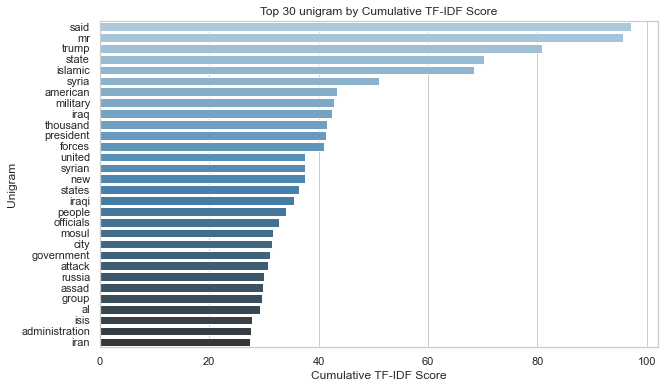

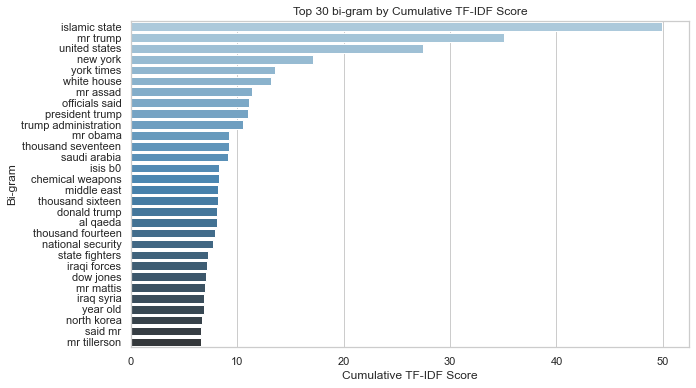

In [31]:
# Setting the aesthetics for the plots
sns.set(style="whitegrid")
# Function to plot top terms
def plot_top_terms(df, term_type, n=30, save_as=None):
    plt.figure(figsize=(10, 6))
    sns.barplot(x="cumulative_tfidf_score", y=term_type, data=df.head(n), palette="Blues_d")
    plt.title(f"Top {n} {term_type} by Cumulative TF-IDF Score")
    plt.xlabel("Cumulative TF-IDF Score")
    plt.ylabel(term_type.capitalize())

    if save_as:
        save_path = os.path.join(output_directory, save_as)
        plt.savefig(save_path, dpi=500, bbox_inches='tight')

    plt.show()

# Plotting top unigrams
plot_top_terms(top_uniGrams_df, "unigram", save_as="top_unigrams.png")

# Plotting top bigrams
plot_top_terms(top_biGrams_df, "bi-gram", save_as="top_bigrams.png")

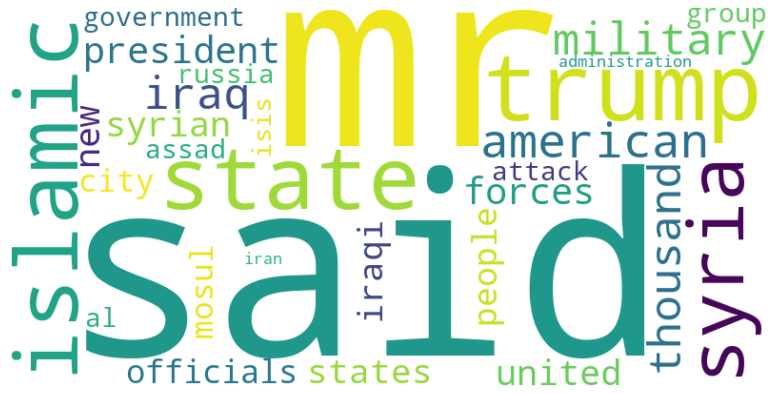

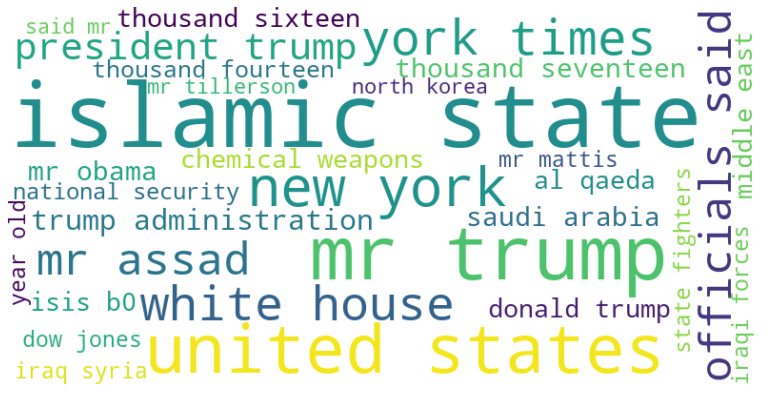

In [32]:

def generate_wordcloud(dataframe, term_column, score_column, save_as=None):
    # Convert DataFrame to dictionary with terms and their cumulative TF-IDF scores
    term_freq = dict(zip(dataframe[term_column], dataframe[score_column]))
    
    # Initialize word cloud object
    wc = WordCloud(width=800, height=400, background_color='white')
    
    # Generate the word cloud from term frequencies
    wordcloud = wc.generate_from_frequencies(term_freq)
    
    # Display the word cloud using matplotlib
    plt.figure(figsize=(15, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Hide the axes

    if save_as:
        save_path = os.path.join(output_directory, save_as)
        plt.savefig(save_path, format='png', dpi=500, bbox_inches='tight')
        
    plt.show()

# Generate and show the word cloud for unigrams
generate_wordcloud(top_uniGrams_df, 'unigram', 'cumulative_tfidf_score', save_as='unigram_wordcloud.png')

# Generate and show the word cloud for bigrams
generate_wordcloud(top_biGrams_df, 'bi-gram', 'cumulative_tfidf_score', save_as='bigram_wordcloud.png')


# Topic modeling

In [23]:
from gensim import corpora
from gensim.models.ldamodel import LdaModel
import gensim

import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

## Creating a Dictionary and Corpus

In [18]:
# Tokenize the documents
tokenized_docs = [doc.split() for doc in cleaned_contents]

# Create a Gensim Dictionary: maps words to ids
dictionary = corpora.Dictionary(tokenized_docs)

# Filter out extremes to remove uninformative tokens
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=100000)

# Create a Gensim Corpus
corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]


## Training the LDA Model and Viewing the Topics

In [19]:
# Set training parameters.
num_topics = 5  # number of topics to extract
passes = 10  # number of passes through the corpus during training

# Train the LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=passes)

for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))


## Model outputs and Visualizations

In [ ]:
output_directory = "lda_output"
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Range of topics to explore
topic_counts = [5, 10, 15, 20]  
passes = 10  # Number of passes through the corpus

for num_topics in topic_counts:
    # Train the LDA model
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=passes)

    # Save the model to disk
    lda_vis = gensimvis.prepare(lda_model, corpus, dictionary)
    pyLDAvis.save_html(lda_vis, f"lda_output/lda_vis_{num_topics}_topics.html")

    # Create a file to store the summary of the model
    output_file = os.path.join(output_directory, f"lda_summary_{num_topics}_topics.txt")
    with open(output_file, "w", encoding="utf-8") as file:
        file.write(f"LDA Model with {num_topics} Topics\n")
        file.write("===================================\n")
        
        # Write each topic and the top words for the topic
        for idx, topic in lda_model.print_topics(-1):
            file.write(f'Topic: {idx} \nWords: {topic}\n\n')

    print(f"Finished training and saving model with {num_topics} topics.")